# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

In [2]:
#reading in an image

def read_image(image_path):
    "Reads and turns the image wrapper"
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    "Shows how an image is represented"
    
    #reading in an image
    image = mpimg.imread(image_path)
    
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #if call as plot.imshow(gray,cmap='gray') to show a grayscale image, or 
                       #just the def'n
    return image

#defining read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]
#test_videos = [read_image('test_videos/' + i) for i in os.listdir('test_videos/')]


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
   
    #FIX THE wrong slope definition names and change the variables. 

    left_x1 = []
    left_y1 = []
    left_x2 = []
    left_y2 = []
    right_x1 = []
    right_y1 = []
    right_x2 = []
    right_y2 = []

    start_guess = 320
    end_point = 550
    
    #Starting point for the line is a guess stated above. Find the best values after several test runs
    
    for line in lines:

        
        for x1,y1,x2,y2 in line:
 
            #note that the slope is flipped from the usual mathematical notation since we 
            #are not in the first quadrant, image space from bottom left corner going from 5XX to 0 
            #in the y direction and 0 to 9XX in the x instead of 0 to 5XX in y and 0 to 9XX in x.
        
            slope = get_slope(x1,y1,x2,y2)
            if slope < 0:

                if slope > -.5 or slope < -.9:
                    continue        
                left_x1.append(x1)
                left_y1.append(y1)
                left_x2.append(x2)
                left_y2.append(y2)
            else:
      
                if slope < .5 or slope > .9:
                    continue        
                right_x1.append(x1)
                right_y1.append(y1)
                right_x2.append(x2)
                right_y2.append(y2)
                
    try:
        avg_right_x1 = float(np.mean(right_x1))
        avg_right_y1 = float(np.mean(right_y1))
        avg_right_x2 = float(np.mean(right_x2))
        avg_right_y2 = float(np.mean(right_y2))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = start_guess
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = end_point
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        print(123)
        pass

    try:
        avg_left_x1 = float(np.mean(left_x1))
        avg_left_y1 = float(np.mean(left_y1))
        avg_left_x2 = float(np.mean(left_x2))
        avg_left_y2 = float(np.mean(left_y2))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = start_guess
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = end_point
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")
#os.listdir("test_videos/")

['download.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# todo not hard code

def draw_lane_lines(image):

    #image = mpimg.imread('test_images/solidWhiteCurve.jpg') THIS WAS MY MISTAKE! WHY THE VIDEO WAS ONE FRAME
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # plt.imshow(gray, cmap='gray')
    # mpimg.imsave("test_images/solidWhiteCurve_Gray.jpg", gray)

    kernel_size = 5
    gaussian_image = gaussian_blur(gray,kernel_size)

    canny_grey = canny(gaussian_image, 50, 150)
    #plt.imshow(canny_grey, cmap='Greys_r')

    imshape = image.shape
    #print(imshape)

    vertices = np.array([[(0,imshape[0]),(480, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)

    ry_img = region_of_interest(canny_grey,vertices)
    
    rho = 2
    theta = np.pi / 180 * 1
    threshold = 20
    min_line_len = 29
    max_line_gap = 10
    hough_image = hough_lines(ry_img, rho, theta, threshold,
                          min_line_len, max_line_gap)

    final_result = weighted_img(hough_image,image)


    plt.imshow(final_result)

    return final_result



#draw_lane_lines(test_images[0])

#remove the above????




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    """Puts image through pipeline and returns 3-channel image for video processing"""
    
    result = draw_lane_lines(image)
    print(result.shape)
    return result


Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
(540, 960, 3)


  1%|▍                                         | 2/222 [00:00<00:13, 16.67it/s]

(540, 960, 3)
(540, 960, 3)


  2%|▊                                         | 4/222 [00:00<00:12, 17.54it/s]

(540, 960, 3)
(540, 960, 3)


  3%|█▏                                        | 6/222 [00:00<00:11, 18.07it/s]

(540, 960, 3)
(540, 960, 3)


  4%|█▌                                        | 8/222 [00:00<00:11, 18.25it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


  5%|██                                       | 11/222 [00:00<00:10, 19.40it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


  6%|██▌                                      | 14/222 [00:00<00:10, 19.84it/s]

(540, 960, 3)
(540, 960, 3)


  7%|██▉                                      | 16/222 [00:00<00:10, 19.66it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


  9%|███▌                                     | 19/222 [00:00<00:10, 20.16it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 10%|████                                     | 22/222 [00:01<00:09, 20.91it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 11%|████▌                                    | 25/222 [00:01<00:09, 20.97it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 13%|█████▏                                   | 28/222 [00:01<00:09, 20.67it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 14%|█████▋                                   | 31/222 [00:01<00:09, 20.85it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 15%|██████▎                                  | 34/222 [00:01<00:08, 21.11it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 17%|██████▊                                  | 37/222 [00:01<00:08, 21.48it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 18%|███████▍                                 | 40/222 [00:01<00:08, 21.46it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 19%|███████▉                                 | 43/222 [00:02<00:08, 21.68it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 21%|████████▍                                | 46/222 [00:02<00:08, 21.19it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 22%|█████████                                | 49/222 [00:02<00:08, 21.08it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 23%|█████████▌                               | 52/222 [00:02<00:08, 20.88it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 25%|██████████▏                              | 55/222 [00:02<00:08, 20.73it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 26%|██████████▋                              | 58/222 [00:02<00:08, 20.26it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 27%|███████████▎                             | 61/222 [00:02<00:07, 20.22it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 29%|███████████▊                             | 64/222 [00:03<00:08, 19.26it/s]

(540, 960, 3)
(540, 960, 3)


 30%|████████████▏                            | 66/222 [00:03<00:08, 19.48it/s]

(540, 960, 3)
(540, 960, 3)


 31%|████████████▌                            | 68/222 [00:03<00:07, 19.40it/s]

(540, 960, 3)
(540, 960, 3)


 32%|████████████▉                            | 70/222 [00:03<00:07, 19.07it/s]

(540, 960, 3)
(540, 960, 3)


 32%|█████████████▎                           | 72/222 [00:03<00:08, 18.38it/s]

(540, 960, 3)
(540, 960, 3)


 33%|█████████████▋                           | 74/222 [00:03<00:07, 18.52it/s]

(540, 960, 3)
(540, 960, 3)


 34%|██████████████                           | 76/222 [00:03<00:08, 18.22it/s]

(540, 960, 3)
(540, 960, 3)


 35%|██████████████▍                          | 78/222 [00:03<00:08, 17.63it/s]

(540, 960, 3)
(540, 960, 3)


 36%|██████████████▊                          | 80/222 [00:04<00:07, 17.89it/s]

(540, 960, 3)
(540, 960, 3)


 37%|███████████████▏                         | 82/222 [00:04<00:07, 17.97it/s]

(540, 960, 3)
(540, 960, 3)


 38%|███████████████▌                         | 84/222 [00:04<00:07, 18.23it/s]

(540, 960, 3)
(540, 960, 3)


 39%|███████████████▉                         | 86/222 [00:04<00:07, 17.73it/s]

(540, 960, 3)
(540, 960, 3)


 40%|████████████████▎                        | 88/222 [00:04<00:07, 17.82it/s]

(540, 960, 3)
(540, 960, 3)


 41%|████████████████▌                        | 90/222 [00:04<00:07, 17.97it/s]

(540, 960, 3)
(540, 960, 3)


 41%|████████████████▉                        | 92/222 [00:04<00:07, 17.94it/s]

(540, 960, 3)
(540, 960, 3)


 42%|█████████████████▎                       | 94/222 [00:04<00:07, 17.87it/s]

(540, 960, 3)
(540, 960, 3)


 43%|█████████████████▋                       | 96/222 [00:04<00:07, 17.96it/s]

(540, 960, 3)
(540, 960, 3)


 44%|██████████████████                       | 98/222 [00:04<00:06, 18.42it/s]

(540, 960, 3)
(540, 960, 3)


 45%|██████████████████                      | 100/222 [00:05<00:06, 18.30it/s]

(540, 960, 3)
(540, 960, 3)


 46%|██████████████████▍                     | 102/222 [00:05<00:06, 18.47it/s]

(540, 960, 3)
(540, 960, 3)


 47%|██████████████████▋                     | 104/222 [00:05<00:06, 17.98it/s]

(540, 960, 3)
(540, 960, 3)


 48%|███████████████████                     | 106/222 [00:05<00:06, 17.99it/s]

(540, 960, 3)
(540, 960, 3)


 49%|███████████████████▍                    | 108/222 [00:05<00:06, 17.95it/s]

(540, 960, 3)
(540, 960, 3)


 50%|███████████████████▊                    | 110/222 [00:05<00:06, 17.50it/s]

(540, 960, 3)
(540, 960, 3)


 50%|████████████████████▏                   | 112/222 [00:05<00:06, 17.33it/s]

(540, 960, 3)
(540, 960, 3)


 51%|████████████████████▌                   | 114/222 [00:05<00:06, 17.13it/s]

(540, 960, 3)
(540, 960, 3)


 52%|████████████████████▉                   | 116/222 [00:06<00:06, 17.34it/s]

(540, 960, 3)
(540, 960, 3)


 53%|█████████████████████▎                  | 118/222 [00:06<00:06, 17.04it/s]

(540, 960, 3)
(540, 960, 3)


 54%|█████████████████████▌                  | 120/222 [00:06<00:05, 17.65it/s]

(540, 960, 3)
(540, 960, 3)


 55%|█████████████████████▉                  | 122/222 [00:06<00:05, 17.99it/s]

(540, 960, 3)
(540, 960, 3)


 56%|██████████████████████▎                 | 124/222 [00:06<00:05, 18.20it/s]

(540, 960, 3)
(540, 960, 3)


 57%|██████████████████████▋                 | 126/222 [00:06<00:05, 18.24it/s]

(540, 960, 3)
(540, 960, 3)


 58%|███████████████████████                 | 128/222 [00:06<00:05, 18.43it/s]

(540, 960, 3)
(540, 960, 3)


 59%|███████████████████████▍                | 130/222 [00:06<00:05, 17.91it/s]

(540, 960, 3)
(540, 960, 3)


 59%|███████████████████████▊                | 132/222 [00:06<00:05, 17.89it/s]

(540, 960, 3)
(540, 960, 3)


 60%|████████████████████████▏               | 134/222 [00:07<00:04, 17.69it/s]

(540, 960, 3)
(540, 960, 3)


 61%|████████████████████████▌               | 136/222 [00:07<00:04, 17.79it/s]

(540, 960, 3)
(540, 960, 3)


 62%|████████████████████████▊               | 138/222 [00:07<00:04, 18.00it/s]

(540, 960, 3)
(540, 960, 3)


 63%|█████████████████████████▏              | 140/222 [00:07<00:04, 18.10it/s]

(540, 960, 3)
(540, 960, 3)


 64%|█████████████████████████▌              | 142/222 [00:07<00:04, 18.13it/s]

(540, 960, 3)
(540, 960, 3)


 65%|█████████████████████████▉              | 144/222 [00:07<00:04, 17.62it/s]

(540, 960, 3)
(540, 960, 3)


 66%|██████████████████████████▎             | 146/222 [00:07<00:04, 17.83it/s]

(540, 960, 3)
(540, 960, 3)


 67%|██████████████████████████▋             | 148/222 [00:07<00:04, 18.23it/s]

(540, 960, 3)
(540, 960, 3)


 68%|███████████████████████████             | 150/222 [00:07<00:03, 18.67it/s]

(540, 960, 3)
(540, 960, 3)


 68%|███████████████████████████▍            | 152/222 [00:08<00:03, 19.05it/s]

(540, 960, 3)
(540, 960, 3)


 69%|███████████████████████████▋            | 154/222 [00:08<00:03, 19.21it/s]

(540, 960, 3)
(540, 960, 3)


 70%|████████████████████████████            | 156/222 [00:08<00:03, 19.39it/s]

(540, 960, 3)
(540, 960, 3)


 71%|████████████████████████████▍           | 158/222 [00:08<00:03, 19.45it/s]

(540, 960, 3)
(540, 960, 3)


 72%|████████████████████████████▊           | 160/222 [00:08<00:03, 19.61it/s]

(540, 960, 3)
(540, 960, 3)


 73%|█████████████████████████████▏          | 162/222 [00:08<00:03, 19.61it/s]

(540, 960, 3)
(540, 960, 3)


 74%|█████████████████████████████▌          | 164/222 [00:08<00:03, 19.21it/s]

(540, 960, 3)
(540, 960, 3)


 75%|█████████████████████████████▉          | 166/222 [00:08<00:02, 18.84it/s]

(540, 960, 3)
(540, 960, 3)


 76%|██████████████████████████████▎         | 168/222 [00:08<00:02, 18.74it/s]

(540, 960, 3)
(540, 960, 3)


 77%|██████████████████████████████▋         | 170/222 [00:08<00:02, 18.36it/s]

(540, 960, 3)
(540, 960, 3)


 77%|██████████████████████████████▉         | 172/222 [00:09<00:02, 17.96it/s]

(540, 960, 3)
(540, 960, 3)


 78%|███████████████████████████████▎        | 174/222 [00:09<00:02, 18.13it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 80%|███████████████████████████████▉        | 177/222 [00:09<00:02, 18.69it/s]

(540, 960, 3)
(540, 960, 3)


 81%|████████████████████████████████▎       | 179/222 [00:09<00:02, 18.74it/s]

(540, 960, 3)
(540, 960, 3)


 82%|████████████████████████████████▌       | 181/222 [00:09<00:02, 19.10it/s]

(540, 960, 3)
(540, 960, 3)


 82%|████████████████████████████████▉       | 183/222 [00:09<00:02, 19.31it/s]

(540, 960, 3)
(540, 960, 3)


 83%|█████████████████████████████████▎      | 185/222 [00:09<00:01, 19.23it/s]

(540, 960, 3)
(540, 960, 3)


 84%|█████████████████████████████████▋      | 187/222 [00:09<00:01, 19.34it/s]

(540, 960, 3)
(540, 960, 3)


 85%|██████████████████████████████████      | 189/222 [00:09<00:01, 18.92it/s]

(540, 960, 3)
(540, 960, 3)


 86%|██████████████████████████████████▍     | 191/222 [00:10<00:01, 19.01it/s]

(540, 960, 3)
(540, 960, 3)


 87%|██████████████████████████████████▊     | 193/222 [00:10<00:01, 18.92it/s]

(540, 960, 3)
(540, 960, 3)


 88%|███████████████████████████████████▏    | 195/222 [00:10<00:01, 18.95it/s]

(540, 960, 3)
(540, 960, 3)


 89%|███████████████████████████████████▍    | 197/222 [00:10<00:01, 18.51it/s]

(540, 960, 3)
(540, 960, 3)


 90%|███████████████████████████████████▊    | 199/222 [00:10<00:01, 18.77it/s]

(540, 960, 3)
(540, 960, 3)


 91%|████████████████████████████████████▏   | 201/222 [00:10<00:01, 19.07it/s]

(540, 960, 3)
(540, 960, 3)


 91%|████████████████████████████████████▌   | 203/222 [00:10<00:01, 18.74it/s]

(540, 960, 3)
(540, 960, 3)


 92%|████████████████████████████████████▉   | 205/222 [00:10<00:00, 18.26it/s]

(540, 960, 3)
(540, 960, 3)


 93%|█████████████████████████████████████▎  | 207/222 [00:10<00:00, 17.94it/s]

(540, 960, 3)
(540, 960, 3)


 94%|█████████████████████████████████████▋  | 209/222 [00:11<00:00, 17.77it/s]

(540, 960, 3)
(540, 960, 3)


 95%|██████████████████████████████████████  | 211/222 [00:11<00:00, 17.52it/s]

(540, 960, 3)
(540, 960, 3)


 96%|██████████████████████████████████████▍ | 213/222 [00:11<00:00, 18.20it/s]

(540, 960, 3)
(540, 960, 3)


 97%|██████████████████████████████████████▋ | 215/222 [00:11<00:00, 18.55it/s]

(540, 960, 3)
(540, 960, 3)


 98%|███████████████████████████████████████ | 217/222 [00:11<00:00, 18.49it/s]

(540, 960, 3)
(540, 960, 3)


 99%|███████████████████████████████████████▍| 219/222 [00:11<00:00, 18.29it/s]

(540, 960, 3)
(540, 960, 3)


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 18.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.4 s


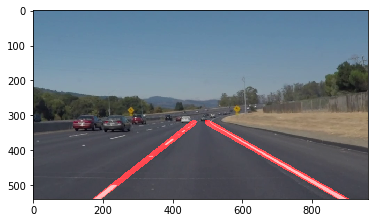

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio = False)


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = "yellow.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip2))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Left - min and max 279 685 589 469
Right - min and max 450 361 1092 677
(720, 1280, 3)
[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4


  0%|                                                  | 0/251 [00:00<?, ?it/s]

Left - min and max 279 685 589 469
Right - min and max 450 361 1092 677
(720, 1280, 3)


  0%|▏                                         | 1/251 [00:00<00:35,  7.14it/s]

Left - min and max 259 685 622 449
Right - min and max 408 360 1094 676
(720, 1280, 3)


  1%|▎                                         | 2/251 [00:00<00:34,  7.13it/s]

Left - min and max 197 685 615 453
Right - min and max 411 361 1094 675
(720, 1280, 3)


  1%|▌                                         | 3/251 [00:00<00:33,  7.35it/s]

Left - min and max 258 685 608 453
Right - min and max 402 360 807 508
(720, 1280, 3)


  2%|▋                                         | 4/251 [00:00<00:31,  7.76it/s]

Left - min and max 264 685 608 454
Right - min and max 471 362 821 517
(720, 1280, 3)


  2%|▊                                         | 5/251 [00:00<00:30,  8.08it/s]

Left - min and max 260 685 621 451
Right - min and max 434 362 856 527
(720, 1280, 3)


  2%|█                                         | 6/251 [00:00<00:29,  8.19it/s]

Left - min and max 284 685 623 446
Right - min and max 401 361 856 537
(720, 1280, 3)


  3%|█▏                                        | 7/251 [00:00<00:30,  7.88it/s]

Left - min and max 263 685 582 474
Right - min and max 401 362 880 552
(720, 1280, 3)


  3%|█▎                                        | 8/251 [00:01<00:31,  7.65it/s]

Left - min and max 265 684 602 457
Right - min and max 402 361 910 569
(720, 1280, 3)


  4%|█▌                                        | 9/251 [00:01<00:31,  7.73it/s]

Left - min and max 271 684 614 451
Right - min and max 432 362 949 593
(720, 1280, 3)


  4%|█▋                                       | 10/251 [00:01<00:31,  7.74it/s]

Left - min and max 300 682 596 462
Right - min and max 417 362 1002 625
(720, 1280, 3)


  4%|█▊                                       | 11/251 [00:01<00:31,  7.72it/s]

Left - min and max 285 684 594 463
Right - min and max 406 362 1070 676
(720, 1280, 3)


  5%|█▉                                       | 12/251 [00:01<00:30,  7.79it/s]

Left - min and max 273 684 595 461
Right - min and max 403 361 1077 678
(720, 1280, 3)


  5%|██                                       | 13/251 [00:01<00:30,  7.76it/s]

Left - min and max 298 684 602 456
Right - min and max 449 362 1078 677
(720, 1280, 3)


  6%|██▎                                      | 14/251 [00:01<00:30,  7.81it/s]

Left - min and max 270 685 644 393
Right - min and max 402 365 1098 676
(720, 1280, 3)


  6%|██▍                                      | 15/251 [00:01<00:30,  7.79it/s]

Left - min and max 272 685 598 458
Right - min and max 594 407 847 509
(720, 1280, 3)


  6%|██▌                                      | 16/251 [00:02<00:31,  7.43it/s]

Left - min and max 275 683 601 456
Right - min and max 398 366 822 516
(720, 1280, 3)


  7%|██▊                                      | 17/251 [00:02<00:31,  7.36it/s]

Left - min and max 275 684 590 464
Right - min and max 399 367 847 528
(720, 1280, 3)


  7%|██▉                                      | 18/251 [00:02<00:30,  7.63it/s]

Left - min and max 275 684 641 393
Right - min and max 587 408 858 540
(720, 1280, 3)


  8%|███                                      | 19/251 [00:02<00:29,  7.81it/s]

Left - min and max 287 684 589 464
Right - min and max 400 362 882 555
(720, 1280, 3)


  8%|███▎                                     | 20/251 [00:02<00:30,  7.63it/s]

Left - min and max 275 684 578 471
Right - min and max 397 361 913 573
(720, 1280, 3)


  8%|███▍                                     | 21/251 [00:02<00:29,  7.90it/s]

Left - min and max 273 683 604 459
Right - min and max 435 361 954 596
(720, 1280, 3)


  9%|███▌                                     | 22/251 [00:02<00:29,  7.82it/s]

Left - min and max 277 684 572 474
Right - min and max 580 388 1010 629
(720, 1280, 3)


  9%|███▊                                     | 23/251 [00:02<00:29,  7.73it/s]

Left - min and max 274 684 570 475
Right - min and max 545 346 1076 709
(720, 1280, 3)


 10%|███▉                                     | 24/251 [00:03<00:28,  7.84it/s]

Left - min and max 273 683 629 391
Right - min and max 577 407 1070 677
(720, 1280, 3)


 10%|████                                     | 25/251 [00:03<00:28,  7.80it/s]

Left - min and max 271 685 593 466
Right - min and max 428 349 1075 675
(720, 1280, 3)


 10%|████▏                                    | 26/251 [00:03<00:28,  7.82it/s]

Left - min and max 274 684 564 483
Right - min and max 582 414 1090 675
(720, 1280, 3)


 11%|████▍                                    | 27/251 [00:03<00:28,  7.85it/s]

Left - min and max 271 685 555 487
Right - min and max 573 408 849 510
(720, 1280, 3)


 11%|████▌                                    | 28/251 [00:03<00:28,  7.73it/s]

Left - min and max 267 685 547 494
Right - min and max 392 369 852 520
(720, 1280, 3)


 12%|████▋                                    | 29/251 [00:03<00:28,  7.83it/s]

Left - min and max 268 684 594 466
Right - min and max 607 391 841 531
(720, 1280, 3)


 12%|████▉                                    | 30/251 [00:03<00:28,  7.88it/s]

Left - min and max 280 685 528 507
Right - min and max 548 415 861 544
(720, 1280, 3)


 12%|█████                                    | 31/251 [00:03<00:28,  7.73it/s]

Left - min and max 264 684 575 477
Right - min and max 552 325 885 557
(720, 1280, 3)


 13%|█████▏                                   | 32/251 [00:04<00:28,  7.70it/s]

Left - min and max 262 685 646 435
Right - min and max 696 407 919 579
(720, 1280, 3)


 13%|█████▍                                   | 33/251 [00:04<00:28,  7.58it/s]

Left - min and max 261 685 569 477
Right - min and max 597 392 962 604
(720, 1280, 3)


 14%|█████▌                                   | 34/251 [00:04<00:28,  7.59it/s]

Left - min and max 261 685 701 408
Right - min and max 539 386 1022 640
(720, 1280, 3)


 14%|█████▋                                   | 35/251 [00:04<00:28,  7.47it/s]

Left - min and max 266 685 562 487
Right - min and max 506 299 1087 678
(720, 1280, 3)


 14%|█████▉                                   | 36/251 [00:04<00:28,  7.52it/s]

Left - min and max 259 685 584 394
Right - min and max 558 396 1087 677
(720, 1280, 3)


 15%|██████                                   | 37/251 [00:04<00:28,  7.64it/s]

Left - min and max 255 685 569 482
Right - min and max 528 329 1087 678
(720, 1280, 3)


 15%|██████▏                                  | 38/251 [00:04<00:28,  7.57it/s]

Left - min and max 255 685 555 491
Right - min and max 470 298 1063 677
(720, 1280, 3)


 16%|██████▎                                  | 39/251 [00:05<00:27,  7.71it/s]

Left - min and max 256 685 584 473
Right - min and max 481 295 847 515
(720, 1280, 3)


 16%|██████▌                                  | 40/251 [00:05<00:26,  7.96it/s]

Left - min and max 274 684 695 402
Right - min and max 463 290 829 524
(720, 1280, 3)


 16%|██████▋                                  | 41/251 [00:05<00:26,  7.79it/s]

Left - min and max 256 685 618 454
Right - min and max 473 290 847 532
(720, 1280, 3)


 17%|██████▊                                  | 42/251 [00:05<00:27,  7.63it/s]

Left - min and max 279 686 608 460
Right - min and max 480 290 1080 715
(720, 1280, 3)


 17%|███████                                  | 43/251 [00:05<00:28,  7.40it/s]

Left - min and max 255 686 601 459
Right - min and max 459 290 896 563
(720, 1280, 3)


 18%|███████▏                                 | 44/251 [00:05<00:27,  7.48it/s]

Left - min and max 258 685 602 459
Right - min and max 457 290 1081 714
(720, 1280, 3)


 18%|███████▎                                 | 45/251 [00:05<00:27,  7.53it/s]

Left - min and max 261 686 592 469
Right - min and max 455 290 980 612
(720, 1280, 3)


 18%|███████▌                                 | 46/251 [00:05<00:27,  7.58it/s]

Left - min and max 262 685 599 465
Right - min and max 454 297 1047 650
(720, 1280, 3)


 19%|███████▋                                 | 47/251 [00:06<00:26,  7.59it/s]

Left - min and max 263 685 682 412
Right - min and max 450 290 1096 676
(720, 1280, 3)


 19%|███████▊                                 | 48/251 [00:06<00:27,  7.34it/s]

Left - min and max 264 685 594 468
Right - min and max 462 295 1096 714
(720, 1280, 3)


 20%|████████                                 | 49/251 [00:06<00:28,  7.06it/s]

Left - min and max 228 685 604 459
Right - min and max 475 293 1095 678
(720, 1280, 3)


 20%|████████▏                                | 50/251 [00:06<00:28,  7.04it/s]

Left - min and max 269 685 595 464
Right - min and max 451 291 805 509
(720, 1280, 3)


 20%|████████▎                                | 51/251 [00:06<00:28,  7.00it/s]

Left - min and max 269 684 663 411
Right - min and max 447 290 1080 713
(720, 1280, 3)


 21%|████████▍                                | 52/251 [00:06<00:28,  7.04it/s]

Left - min and max 269 685 675 291
Right - min and max 420 290 844 527
(720, 1280, 3)


 21%|████████▋                                | 53/251 [00:06<00:27,  7.18it/s]

Left - min and max 267 684 672 305
Right - min and max 455 291 852 537
(720, 1280, 3)


 22%|████████▊                                | 54/251 [00:07<00:27,  7.14it/s]

Left - min and max 273 684 560 488
Right - min and max 455 292 874 552
(720, 1280, 3)


 22%|████████▉                                | 55/251 [00:07<00:28,  6.89it/s]

Left - min and max 275 682 563 291
Right - min and max 427 295 892 569
(720, 1280, 3)


 22%|█████████▏                               | 56/251 [00:07<00:28,  6.81it/s]

Left - min and max 270 684 538 501
Right - min and max 451 290 941 590
(720, 1280, 3)


 23%|█████████▎                               | 57/251 [00:07<00:27,  6.99it/s]

Left - min and max 271 685 606 290
Right - min and max 412 290 976 621
(720, 1280, 3)


 23%|█████████▍                               | 58/251 [00:07<00:27,  7.05it/s]

Left - min and max 273 685 680 295
Right - min and max 415 290 1065 663
(720, 1280, 3)


 24%|█████████▋                               | 59/251 [00:07<00:27,  7.09it/s]

Left - min and max 268 685 541 294
Right - min and max 406 290 1089 678
(720, 1280, 3)


 24%|█████████▊                               | 60/251 [00:07<00:26,  7.11it/s]

Left - min and max 268 685 523 294
Right - min and max 411 290 1091 676
(720, 1280, 3)


 24%|█████████▉                               | 61/251 [00:08<00:27,  6.87it/s]

Left - min and max 212 684 666 290
Right - min and max 388 290 1091 674
(720, 1280, 3)


 25%|██████████▏                              | 62/251 [00:08<00:27,  6.77it/s]

Left - min and max 264 685 673 414
Right - min and max 411 290 812 508
(720, 1280, 3)


 25%|██████████▎                              | 63/251 [00:08<00:27,  6.80it/s]

Left - min and max 269 684 667 303
Right - min and max 403 290 1113 719
(720, 1280, 3)


 25%|██████████▍                              | 64/251 [00:08<00:27,  6.83it/s]

Left - min and max 263 684 637 340
Right - min and max 404 290 843 528
(720, 1280, 3)


 26%|██████████▌                              | 65/251 [00:08<00:26,  6.89it/s]

Left - min and max 260 686 670 290
Right - min and max 407 292 863 541
(720, 1280, 3)


 26%|██████████▊                              | 66/251 [00:08<00:26,  6.89it/s]

Left - min and max 263 685 565 293
Right - min and max 350 291 889 555
(720, 1280, 3)


 27%|██████████▉                              | 67/251 [00:09<00:26,  6.84it/s]

Left - min and max 264 685 668 296
Right - min and max 385 296 921 574
(720, 1280, 3)


 27%|███████████                              | 68/251 [00:09<00:26,  6.84it/s]

Left - min and max 269 684 609 306
Right - min and max 403 290 963 597
(720, 1280, 3)


 27%|███████████▎                             | 69/251 [00:09<00:26,  6.79it/s]

Left - min and max 297 684 557 331
Right - min and max 414 301 1022 631
(720, 1280, 3)


 28%|███████████▍                             | 70/251 [00:09<00:25,  7.02it/s]

Left - min and max 275 685 641 296
Right - min and max 395 291 1112 719
(720, 1280, 3)


 28%|███████████▌                             | 71/251 [00:09<00:25,  6.98it/s]

Left - min and max 277 684 666 292
Right - min and max 404 293 1104 676
(720, 1280, 3)


 29%|███████████▊                             | 72/251 [00:09<00:25,  7.03it/s]

Left - min and max 285 684 633 308
Right - min and max 396 304 1107 673
(720, 1280, 3)


 29%|███████████▉                             | 73/251 [00:09<00:25,  7.02it/s]

Left - min and max 199 684 599 293
Right - min and max 399 290 1095 664
(720, 1280, 3)


 29%|████████████                             | 74/251 [00:10<00:25,  7.03it/s]

Left - min and max 283 684 591 297
Right - min and max 399 364 824 514
(720, 1280, 3)


 30%|████████████▎                            | 75/251 [00:10<00:25,  6.91it/s]

Left - min and max 286 685 613 307
Right - min and max 797 497 839 521
(720, 1280, 3)


 30%|████████████▍                            | 76/251 [00:10<00:25,  6.95it/s]

Left - min and max 288 684 617 300
Right - min and max 523 409 857 533
(720, 1280, 3)


 31%|████████████▌                            | 77/251 [00:10<00:24,  7.14it/s]

Left - min and max 290 684 623 407
Right - min and max 509 393 880 545
(720, 1280, 3)


 31%|████████████▋                            | 78/251 [00:10<00:24,  7.17it/s]

Left - min and max 312 684 618 456
Right - min and max 640 407 908 560
(720, 1280, 3)


 31%|████████████▉                            | 79/251 [00:10<00:24,  7.07it/s]

Left - min and max 291 684 568 487
Right - min and max 617 411 942 579
(720, 1280, 3)


 32%|█████████████                            | 80/251 [00:10<00:24,  6.85it/s]

Left - min and max 293 685 606 397
Right - min and max 359 430 990 605
(720, 1280, 3)


 32%|█████████████▏                           | 81/251 [00:11<00:24,  6.88it/s]

Left - min and max 295 684 571 483
Right - min and max 884 552 1055 640
(720, 1280, 3)


 33%|█████████████▍                           | 82/251 [00:11<00:24,  6.77it/s]

Left - min and max 292 685 558 438
Right - min and max 593 417 1117 675
(720, 1280, 3)


 33%|█████████████▌                           | 83/251 [00:11<00:24,  6.89it/s]

Left - min and max 294 684 601 389
Right - min and max 610 394 1116 671
(720, 1280, 3)


 33%|█████████████▋                           | 84/251 [00:11<00:23,  7.01it/s]

Left - min and max 284 683 599 392
Right - min and max 555 404 1116 674
(720, 1280, 3)


 34%|█████████████▉                           | 85/251 [00:11<00:23,  6.97it/s]

Left - min and max 297 684 650 386
Right - min and max 710 458 809 509
(720, 1280, 3)


 34%|██████████████                           | 86/251 [00:11<00:24,  6.82it/s]

Left - min and max 299 683 601 467
Right - min and max 534 395 821 517
(720, 1280, 3)


 35%|██████████████▏                          | 87/251 [00:11<00:24,  6.76it/s]

Left - min and max 302 684 595 413
Right - min and max 602 409 835 526
(720, 1280, 3)


 35%|██████████████▎                          | 88/251 [00:12<00:23,  6.82it/s]

Left - min and max 305 684 587 412
Right - min and max 102 425 862 650
(720, 1280, 3)


 35%|██████████████▌                          | 89/251 [00:12<00:23,  6.88it/s]

Left - min and max 297 683 589 422
Right - min and max 273 429 885 550
(720, 1280, 3)


 36%|██████████████▋                          | 90/251 [00:12<00:23,  6.96it/s]

Left - min and max 309 683 674 410
Right - min and max 655 415 914 567
(720, 1280, 3)


 36%|██████████████▊                          | 91/251 [00:12<00:23,  6.74it/s]

Left - min and max 309 683 581 427
Right - min and max 535 328 953 587
(720, 1280, 3)


 37%|███████████████                          | 92/251 [00:12<00:24,  6.55it/s]

Left - min and max 311 683 639 383
Right - min and max 365 410 1003 615
(720, 1280, 3)


 37%|███████████████▏                         | 93/251 [00:12<00:24,  6.39it/s]

Left - min and max 303 684 639 379
Right - min and max 486 327 1075 653
(720, 1280, 3)


 37%|███████████████▎                         | 94/251 [00:12<00:23,  6.63it/s]

Left - min and max 315 683 624 386
Right - min and max 577 383 1115 674
(720, 1280, 3)


 38%|███████████████▌                         | 95/251 [00:13<00:23,  6.71it/s]

Left - min and max 275 682 637 376
Right - min and max 467 303 1117 674
(720, 1280, 3)


 38%|███████████████▋                         | 96/251 [00:13<00:22,  6.87it/s]

Left - min and max 103 683 543 386
Right - min and max 581 383 1116 674
(720, 1280, 3)


 39%|███████████████▊                         | 97/251 [00:13<00:22,  6.91it/s]

Left - min and max 305 687 544 421
Right - min and max 468 304 848 501
(720, 1280, 3)


 39%|████████████████                         | 98/251 [00:13<00:21,  6.98it/s]

Left - min and max 255 688 524 431
Right - min and max 471 323 595 445
(720, 1280, 3)


 39%|████████████████▏                        | 99/251 [00:13<00:22,  6.90it/s]

Left - min and max 224 684 518 389
Right - min and max 545 387 812 513
(720, 1280, 3)


 40%|███████████████▉                        | 100/251 [00:13<00:21,  6.87it/s]

Left - min and max 136 684 504 394
Right - min and max 797 479 852 524
(720, 1280, 3)


 40%|████████████████                        | 101/251 [00:13<00:21,  6.89it/s]

Left - min and max 278 684 481 395
Right - min and max 547 406 858 534
(720, 1280, 3)


 41%|████████████████▎                       | 102/251 [00:14<00:21,  7.01it/s]

Left - min and max 320 683 476 380
Right - min and max 484 410 1101 675
(720, 1280, 3)


 41%|████████████████▍                       | 103/251 [00:14<00:20,  7.18it/s]

Left - min and max 307 684 454 382
Right - min and max 554 407 890 562
(720, 1280, 3)


 41%|████████████████▌                       | 104/251 [00:14<00:20,  7.25it/s]

Left - min and max 291 683 429 388
Right - min and max 521 321 948 587
(720, 1280, 3)


 42%|████████████████▋                       | 105/251 [00:14<00:20,  7.11it/s]

Left - min and max 287 684 378 634
Right - min and max 408 381 999 616
(720, 1280, 3)


 42%|████████████████▉                       | 106/251 [00:14<00:20,  7.00it/s]

Left - min and max 313 463 387 382
Right - min and max 487 306 1171 675
(720, 1280, 3)


 43%|█████████████████                       | 107/251 [00:14<00:20,  6.92it/s]

Left - min and max 306 455 376 393
Right - min and max 447 300 1091 676
(720, 1280, 3)


 43%|█████████████████▏                      | 108/251 [00:14<00:20,  7.02it/s]

ValueError: min() arg is an empty sequence

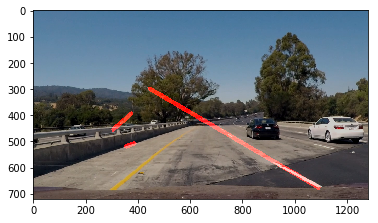

In [19]:
challenge_output = "challenge.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'challenge_output' is not defined